# Electric Vehicle Charging Point Predictor

Using OSM-data to predict where to build an EV Charger


### 1. First getting a City Boundary from OSM
We use the Public OSM Nominatim to get the `osm_id` of a city boundary.
Play around with the search query in `CITY` if you can't find your city.
You can also change the line `best_result = result.json()[0]` if you can't find a query where a result with class `boundary` is the best one.

In [1]:
import requests

In [2]:
NOMINATIM_URL = 'https://nominatim.openstreetmap.org/search'
OVERPASS_URL = 'https://overpass-api.de/api/interpreter'

CITY = "München, Germany"

PARAMS = {
    'q': CITY,
    'format': 'json'
}

result = requests.get(NOMINATIM_URL, params=PARAMS)
best_result = result.json()[0]
from pprint import pprint
pprint(best_result)


{'boundingbox': ['48.0616244', '48.2481162', '11.360777', '11.7229099'],
 'class': 'boundary',
 'display_name': 'München, Bayern, Deutschland',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png',
 'importance': 0.8562108837044543,
 'lat': '48.1371079',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'https://osm.org/copyright',
 'lon': '11.5753822',
 'osm_id': 62428,
 'osm_type': 'relation',
 'place_id': 308026025,
 'type': 'administrative'}


Here we use the `osm_id` we gathered from our Nominatim-Response to download the full "border-geometry" using the OSM Overpass API. We then convert the response to geojson and save it for later.

In [3]:
# getting osm_id to get the boundary from overpass

Failure = False
osm_id = None
if best_result.get('osm_type') != "relation":
    print("Best Result was not a relation, cant continue")
    Failure = True
else:
    osm_id = best_result.get('osm_id')

    
import osm2geojson
import json

resp = osm2geojson.overpass_call(f'''
    [out:json][timeout:25];
    rel({osm_id});
    (._;>>;);
    out geom;
''')
shape = osm2geojson.json2geojson(resp)
with open("border.geojson", "w") as output_file:
    output_file.write(json.dumps(shape))


Now let's try to import this border in geopandas and plot it on a map.
If everything looks good continue with creating a grid.

In [4]:
import pandas as pd
import geopandas as gpd

my_border_polygon = gpd.read_file("border.geojson")
my_border = my_border_polygon.boundary
my_border.explore()

In [5]:
my_border.describe()

count                         2466
unique                         111
top       GEOMETRYCOLLECTION EMPTY
freq                          2356
dtype: object

### 2. Create a Square Grid over the City Boundaries
`Adapted Algorithm from https://wsdookadr.github.io/posts/p4/`
We want to create a grid with 1000m * 1000m = 1m². The grid-length is set in `CELL_SIZE`.
First we have to project our boundary to a meter-based coordinate-system. There it will be a lot easier to calculate our grind.

We first get a very rough bounding box around the city by using `total_bounds`.
Then we have two loops iterating of the whole bounding box from top left all the way to bottom right.
Indices are row first.
We create a Shapely-Polygon for every grid-square, convert the list of polygons to a geopandas dataframe **and set the correct projection**.
After that we plot the new cells and the border. Notice as the cells are touching it becomes a flat box in the plot.

As Cities are not perfectly rectangular we will have some grid squares that are just a tiny bit inside the cityborder with most of their area outside.
In the next step we will start filtering the cells.

EPSG:4326
EPSG:32633
229380.54657757195


<AxesSubplot: >

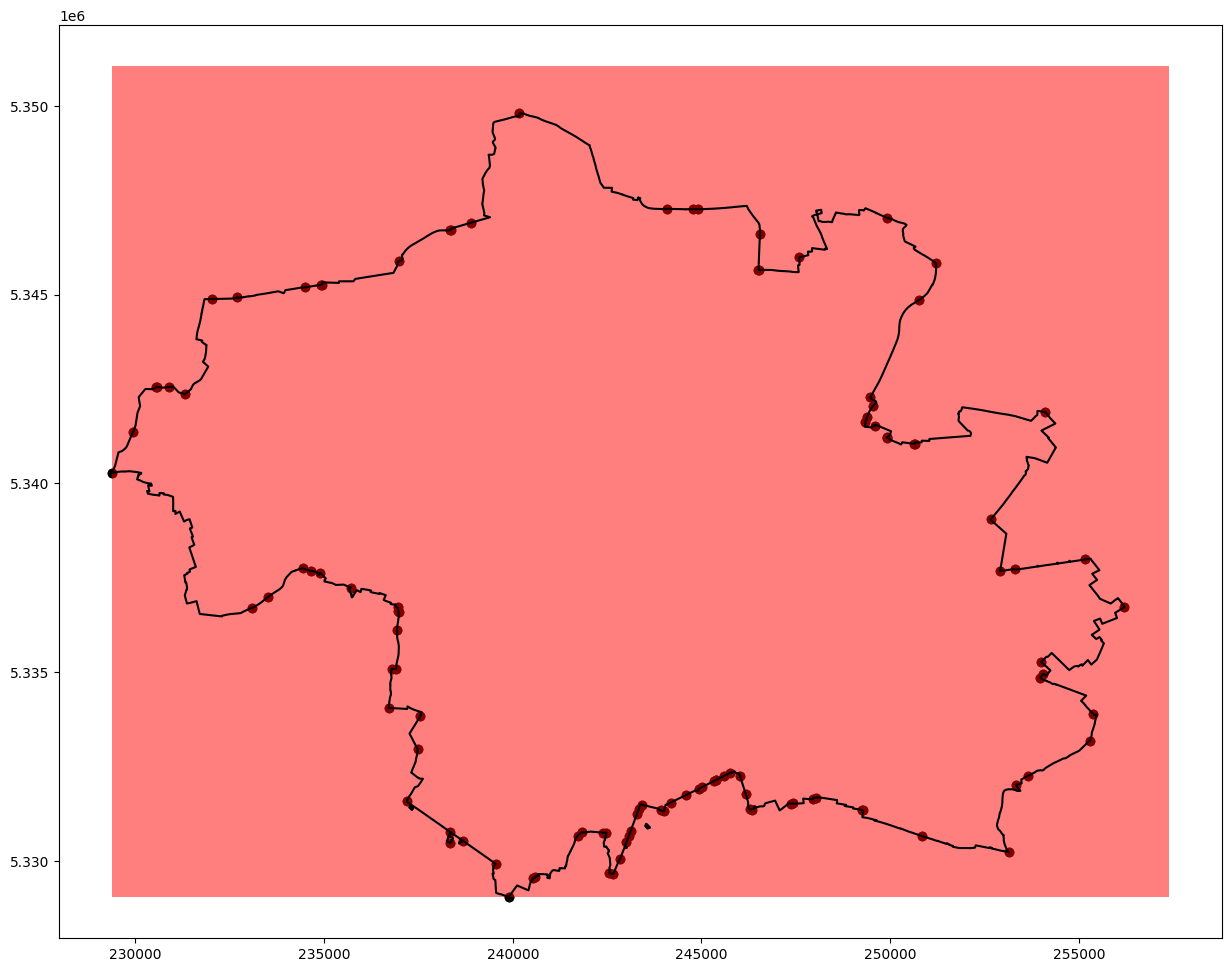

In [6]:
from shapely import Polygon
import numpy as np
import shapely
import matplotlib.pyplot as plt

CELL_SIZE = 1000
#what is the current projection?

print(my_border.crs)
my_border = my_border.to_crs("EPSG:32633")
print(my_border.crs)

xmin, ymin, xmax, ymax= my_border.total_bounds
print(xmin)

cells = list()
id_idx = 0
#CELL_SIZE = CELL_SIZE*ONE_METER
for x0 in np.arange(xmin, xmax+CELL_SIZE, CELL_SIZE):
    for y0 in np.arange(ymin, ymax+CELL_SIZE, CELL_SIZE):
        new_polygon = Polygon(shell=((x0, y0), (x0+CELL_SIZE, y0), (x0+CELL_SIZE, y0+CELL_SIZE), (x0, y0+CELL_SIZE), (x0,y0)))
        cells.append({'id': id_idx, 'geometry': new_polygon})
        id_idx +=1

cells = gpd.GeoDataFrame.from_records(cells)
cells.crs = 'epsg:32633'
#cells.set_crs("EPSG:4326")


fig, ax = plt.subplots(figsize=(15, 15))

my_border.plot(ax=ax, alpha=1.0, color='black')
cells.plot(ax=ax, alpha=0.5, color='red')

#### Filtering our grid squares
To filter our cells we first cut them by using `overlay`.
We use our dataframe of cells and put a mask of the city border on top. Everything outside of the mask will be cut.

Now the grid is not square anymore but instead follows the border perfectly.
Use the interactive map to zoom in and see the new cells.

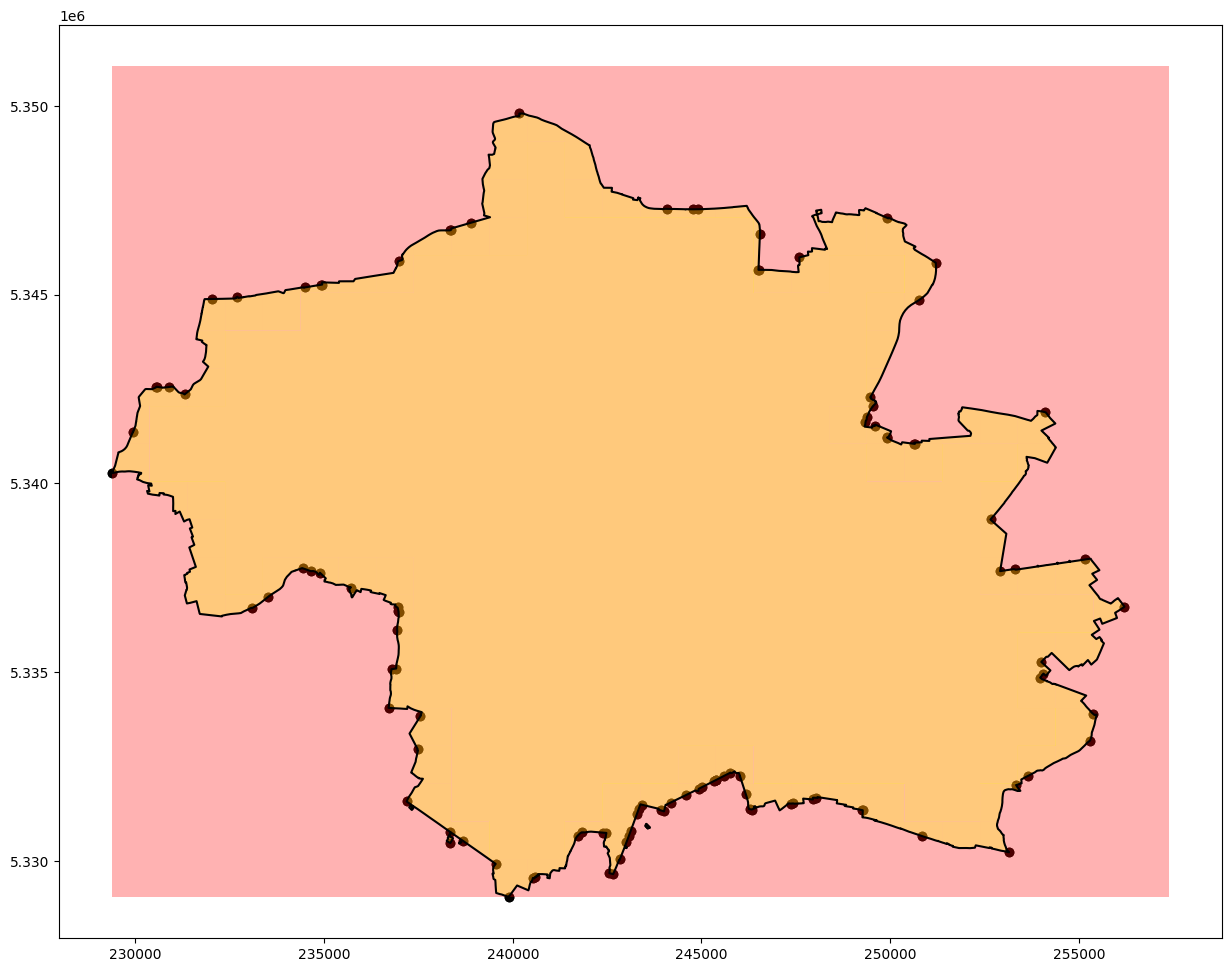

In [7]:
border_frame = gpd.GeoDataFrame(geometry=my_border_polygon.query("type == 'relation'")['geometry'])
border_frame = border_frame.to_crs('EPSG:32633')
result = gpd.overlay(cells, border_frame)

fig, ax = plt.subplots(figsize=(15, 15))

my_border.plot(ax=ax, alpha=1.0, color="black")
cells.plot(ax=ax, alpha=0.3, color='red')
result.plot(ax=ax, alpha=0.3, color='yellow')


result.explore()

In the future we want to do predictions on the cells so we need the them to be at least a certain size to make meaningful predictions.
So we filter any cell that is smaller than `FILTER_PERCENTAGE`. I choose 30% which seems to be ok for now.

We the statement `result['area'] = result['geometry'].area` to calculate the area for every polygon and save the result as its own column in the dataframe. In the next step we can filter based on the new column.

In the new plots you will notice some jagged edges inside the border.

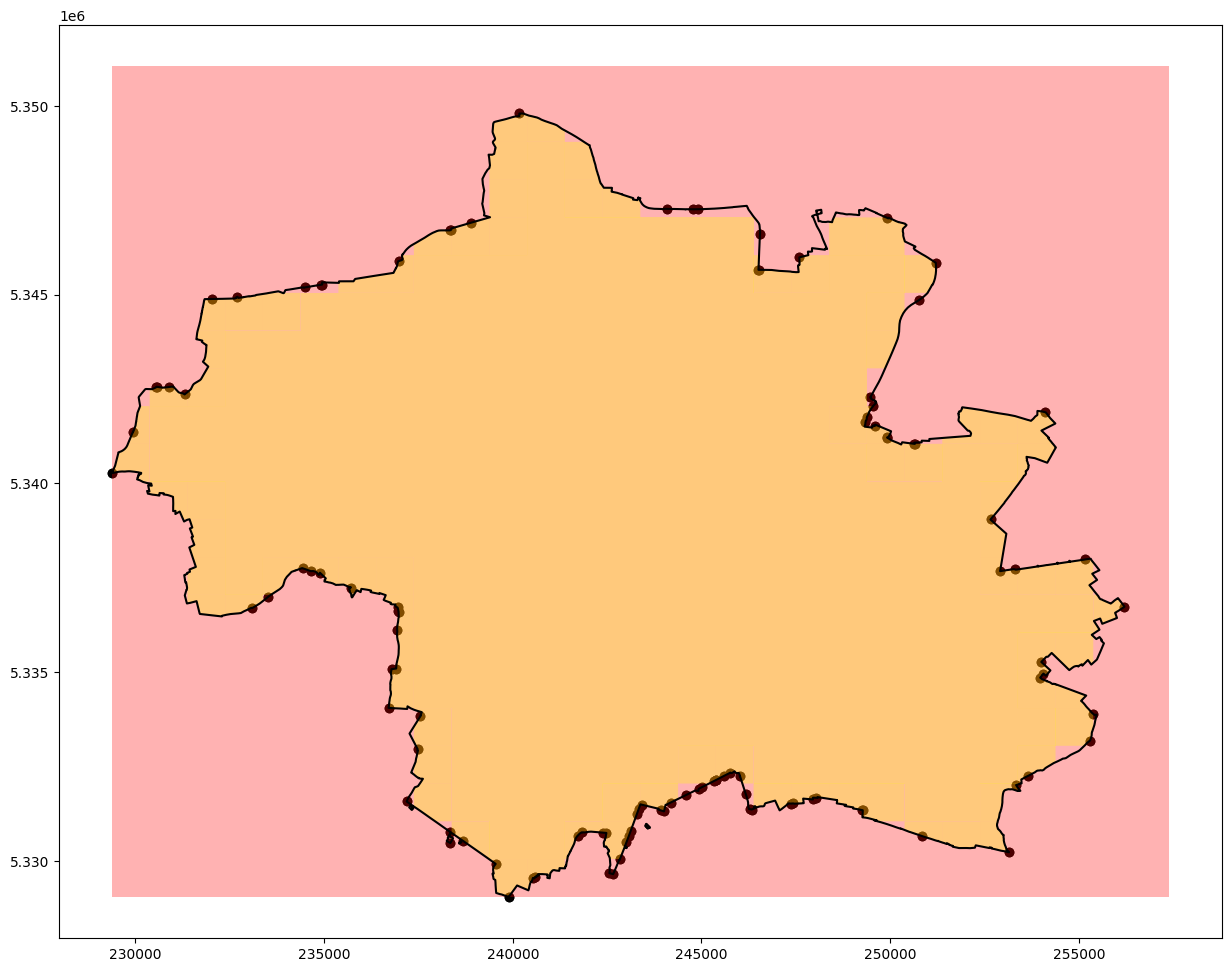

In [8]:

result['area'] = result['geometry'].area # in meters

FILTER_PERCENTAGE = 30

filtered_result = result.loc[result['area'] > (CELL_SIZE * CELL_SIZE)*(30/100) ]

#print(filtered_result.to_crs("EPSG:4326").to_json())

fig, ax = plt.subplots(figsize=(15, 15))

my_border.plot(ax=ax, alpha=1.0, color="black")
cells.plot(ax=ax, alpha=0.3, color='red')
filtered_result.plot(ax=ax, alpha=0.3, color='yellow')


filtered_result.explore()